## Proyecto de Geoinformática: Modelo de Accesibilidad

#### Autores: 
* González, Luis
* Morgado, Julio 

En esta sección se desarrollarán dos modelos de accesibilidad, gravitacional y de agente racional (RAAM). El problema en cuestion es medir la accesibilidad a talleres de bicicleta en la red de ciclovias en la Ciudad de México. En este sentido, la pregunta a responder es qué tan accesible es el servicio de taller de bicicleta en los diferentes kilometros de la red de ciclovias en caso de una falla mecánica. Adicionalmente, el problema busca considerar la demanda del servicio y la distancia de los talleres respecto a la zona de descompostura. A continuación se presentan las paqueterías requeridas para llevar a cabo dichos modelos. 

In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import statsmodels.formula.api as smf
from sklearn.neighbors import BallTree
from shapely.geometry import *
from shapely.ops import nearest_points
from access import Access, weights
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")

**Funciones utilizadas en el código**

La función principal de esta sección de código es *multi_line* la cual llama a *break_line* y a *cut* para poder realizar cortes cada $n$ metros en la red de ciclovias. Lo anterior se debe de realizar puesto que de otra forma tendríamos ciclovias muy largas que tienen diferentes niveles de accesibilidad a taller. Un ejemplo de lo anterior es la ciclovía que conecta Tres Marías, Morelos con la colonia de Lomas de San Ángel al interior de la CDMX; donde la gran extensión de la ciclovía abarca diferentes puntos de la ciudad y, naturalmente, al acceso a talleres va variando. 

Posteriormente, otra de las funciones de interés es la de *KN* la cual con ayuda del algoritmo de BallTree (http://people.ee.duke.edu/~lcarin/liu06a.pdf) podemos calcular de forma más eficiente si existen talleres cercanos a las ciclovías. Más adelante en el documento, se utiliza dicha función con un valor cercano al kilometro asumiendo que en caso de una descompostura, buscaremos un taller cercano y accesible caminando. 

In [11]:
# Función para cortar por tramos las ciclovias en conjunto con break_line y cut.
def multi_line(line, dista):
    '''
    Descripción:
        Función para cortar segmentos de linea de pysal. Se añade la capa de ciclovías o de segmentos
        ya sean line o multiline y se cortan en n (dista) metros.
        El output es una conjunto de lineas segmentadas en la cantidad de metros correspondientes.
    
    Input:
        line - GeoDataFrame de la red de ciclovías u otro conjuntos de lineas o multilineas. 
        dista - Distancia en metros que se desea cortar. 
    
    Output
        GeoDataFrame con los segmentos de lineas correspondientes. 
    '''
    
    if line.geom_type == 'MultiLineString':
        segments = []
        for l in line:
            segments += break_line(l, dista)
    else:
        segments = break_line(line, dista)
    return segments

def break_line(line, dist):
    line = LineString([xy[0:2] for xy in list(line.coords)])
    if line.length <= dist:
        return [line]
    else: 
        segments = cut(line, dist)
        return [segments[0]] + break_line(segments[1], dist)

def cut(line, distance):
    if distance <= 0.0 or distance >= line.length:
        return [line]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        p = line.project(Point(p)) 
        if p == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if p > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

# Función de busqueda para los knn vecinos utilizando BallTree
def KN(gdA, gdB, knn=5,dist_lim=1000):
    '''
    Descripción:
        Función para obtener los vecinos (gdB) correspondientes a los puntos origen (gdA). En este 
        caso, el origen son los centroides de ciclovías y los vecinos son los talleres. El código 
        usa el indexado de BallTree y posteriormente selecciona el número de vecinos (knn) que
        se requieran. Este algoritmo trabaja con distancia euclidiana y tiene un threshold de n 
        (dist_lim) metros a la redonda para encontrar vecinos. 
        
    Input:
        gdA - Puntos origen (centroides de ciclovías)
        gdB - Puntos vecinos (puntos de talleres)
        knn - Número de vecinos o talleres a buscar alrededor de los gdA.  
        dist_lim - Threshold para buscqueda de vecinos en metros. 
    
    Output
        Dos arrays. El primer array son todos los puntos origen; el segundo, un array 
        con dos dimensiones para almacenar los índices de los vecinos de cada punto origen. 
    '''
    nA = list(gdA.geometry.apply(lambda x: (x.x, x.y)))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = BallTree(nB)
    dist, idx = btree.query(np.array(nA), k=knn)
    idx = [list(x) for x in list(idx)]
    for i in range(dist.shape[0]):
        rev_j = list(range(dist.shape[1]))
        rev_j.sort(reverse=True)
        for j in rev_j:
            if dist[i,j]>dist_lim:
                del idx[i][j]
                
    rev_i = list(range(dist.shape[0]))
    rev_i.sort(reverse=True)
    for i in rev_i:
        if len(idx[i])==0:
            del idx[i]
            del nA[i]
    return [Point(x) for x in nA], idx

# Función para convertir y dejar pasar tipos de número y texto
def nconv(n):
    '''
    Descripción:
        Convertir a float valores numericos y deja intactos los string. 
    
    Input:
        n - Número a convertir
    
    Output
        n - Número convertido a float o str.
    '''
    try: 
        return float(n)
    except:
        return n

# Función para revisar las observaciones con texto en columna
def var_rev(df, v_int):
    '''
    Descripción:
        Función para encontrar elementos str en celdas combinadas con numéricos y texto. 
    
    Input:
        df -  DataFrame
        v_int - Variable a analizar
    
    Output
        Elementos textos dentro de la columna. 
    '''
    for v in v_int:  
        r = [x for x in list(df[v]) if re.search('\D', str(x))]
        r = [x for x in r if type(nconv(x))==str]
        print(v, set(r), round(len(r)/df.shape[0]*100,4))

**Conversión de ciclovias a tramos de un kilometro**

Ahora, pasamos a la separación de las ciclovías en tramos de un kilometro cada una. 

In [12]:
# Archivo original de ciclovías en la cdmx por la secretaría de obras de la CDMX y SEDEMA.
ciclo = gpd.read_file('data/ciclovias_cdmx.zip').to_crs(32614)
ciclo_lines = pd.DataFrame({'ID':[], 'NOMBRE':[], 'TIPO_IC':[], 
                            'VIALIDAD':[], 'TIPO_VIA':[], 'ESTADO':[], 
                            'SENTIDO':[], 'INSTANCIA':[], 'AÑO':[],'geometry':[]})
for i in range(ciclo.shape[0]):
    df_l = pd.DataFrame({'ID':ciclo.iloc[i,0], 'NOMBRE':ciclo.iloc[i,1],
                         'TIPO_IC':ciclo.iloc[i,2], 
                         'VIALIDAD':ciclo.iloc[i,3],
                         'TIPO_VIA':ciclo.iloc[i,4], 
                         'ESTADO':ciclo.iloc[i,5], 
                         'SENTIDO':ciclo.iloc[i,6],
                         'INSTANCIA':ciclo.iloc[i,7], 
                         'AÑO':ciclo.iloc[i,8],
                         'geometry':(multi_line(ciclo.iloc[i,-1], 1000))})
    ciclo_lines = ciclo_lines.append(df_l)
    
ciclo_lines = gpd.GeoDataFrame(ciclo_lines, crs=32614)
ciclo_lines.reset_index(drop=True, inplace=True)
ciclo_lines.reset_index(inplace=True)
ciclo_lines.columns = [x.lower() for x in ciclo_lines.columns]
ciclo_lines.rename(columns={'index':'fid', 'id':'fid_org', 'año':'year'}, 
                   inplace=True)
ciclo_centroids = ciclo_lines.copy()

# Extraer centroides de cada tramo de linea
ciclo_centroids.loc[:,'geometry'] = ciclo_centroids.geometry.centroid

# Generar variable con codigo unico para cada punto (después es util para el match entre lineas y centroides)
ciclo_centroids = ciclo_centroids.rename(columns={'fid_org':'id_ciclovia', 'fid':'id_centroid'})

# Exportar resultados para llamarlos en futuros modulos
try:
    ciclo_lines.to_file('products/ciclovias_lines.gpkg', driver='GPKG', layer='ciclovias')
except:
    os.mkdir(os.getcwd() + '\\products')
    ciclo_lines.to_file('products/ciclovias_lines.gpkg', driver='GPKG', layer='ciclovias')
ciclo_centroids.to_file('products/ciclovias_centroids.gpkg', driver='GPKG', layer='ciclovias_ctr')
del ciclo, df_l, i

**Modelo de demanda**

La idea del modelo de demanda es utilizar la información existente del censo de población y vivienda del 2020 del INEGI, sobre todo de la variable respecto al número de viviendas particulares habitadas que disponen de bicicleta como medio de transporte. 
Se optó por trabajar a nivel de manzanas para generar mayor número de puntos desagregados en el espacio para asignar un par de manzanas por cada tramo de ciclovía. En este sentido, el proceso de construir la demanda se resume en 3 pasos:
1) Partir los LineStrings de ciclovías a tramos de $n$ metros y obtener centroides de los mismos. 

2) Obtener número de usuarios aproximados de ciclovías con base al censo de población y la variable *VPH_BICI*.

    2.5) Considerar que posiblemente se requera una extrapolación de datos por cuestiones de confidencialidad y missings. 
   
3) Asignar la demanda estimada a cada tramo de ciclovía utiliznado *KN* y ponderando dicha demanda. 

Para el primer punto, ya vimos anteriormente la función de partición. En el trabajo se utiliza una separación de un kilometro pensando en que una persona camina en promedio un kilometro por 10-15 minutos y que deseamos invertir ese tiempo en buscar un taller cercano que pueda componer nuestra bicicleta en caso de una falla mecánica. 

Respecto al segundo punto, se consideró que el censo de población es la fuente de información más desagregada y con ubicación espacial desagregada que nos puede ayudar a modelar el uso de la bicicleta en la CDMX. La variable de interés es el número de viviendas particulares habitadas que disponen de bicicleta como medio de transporte a nivel de manzanas en la ciudad. Sin embargo, analizando la base de datos hay casí un 30% de la información que está protegida por cuestiones de confidencialidad o no se cuenta con dicha información. Por lo tanto, se considera necesario hacer un sencillo modelo lineal para imputar la información faltante con base a otras variables del censo correlacionadas con nuestra variables de interés.

El modelo sencillo OLS para poder extrapolar los valores faltantes en la variable de interés *VPH_BICI* utilizó las variables siguientes:
- VPH_BICI: viviendas particulares habitadas que disponen de bicicleta como medio de transporte.
- P_12YMAS: población de 12 años y más; para estimar la población que potencialmente usa bicicleta.
- P_60YMAS: población de 60 años y más; para estimar la población que potencialmente usa bicicleta.
- GRAPROES: grado promedio de escolaridad.
- VPH_NDACMM: viviendas particulares habitadas que no disponen de automóvil o camioneta, ni de motocicleta o motoneta.
- POCUPADA: población de 12 años y más ocupada.

Por último, en el punto tres, asignamos el valor predicho por el modelo OLS a las observaciones de VPH_BICI faltantes. Con lo anterior, se completa la base de datos y se puede hacer una mejor estimación de la demanda y un mejor modelo de accesibilidad. En el siguiente bloque de código se presenta la limpieza de datos y la observación de valores nulos o protegidos. 

In [13]:
mza = gpd.read_file('data/manzanas_cdmx.gpkg').to_crs(32614)
pob = pd.read_csv("data/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str, 'MZA':str})
pob['CVEGEO'] = pob['ENTIDAD'] + pob['MUN'] + pob['LOC'] + pob['AGEB'] + pob['MZA']
bi = pd.merge(mza, pob, on='CVEGEO', how='left')
del mza, pob
# Eliminar missing
bi = bi[~bi.GRAPROES.isna()]

v_int = ['VPH_BICI','P_12YMAS','P_60YMAS','PDESOCUP',
         'GRAPROES', 'VPH_NDACMM','POCUPADA']

Primero, se exploró el número de missings o valores reservados por principio de confidencialidad. Como se mencionó anteriormente, vemos que VPH_BICI tiene un porcentaje alto de missings al igual que población desocupada. En el caso de población desocupada, se desecha dicha variable para probar en el modelo OLS porque buscamos reducir el número de imputaciones y tener que modificar en la menor cantidad posible de observaciones.  

In [14]:
# Revisar valores
var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D', '*'} 2.4741
P_60YMAS {'N/D', '*'} 7.0934
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D', '*'} 2.4741
VPH_NDACMM {'N/D', '*'} 8.5554
POCUPADA {'N/D', '*'} 2.5559


Intentando reducir el número valores nulos o protegidos se decidió remplazar las variables de población, viviendas y personas ocupadas con un 1. Lo anterior, se asume bajo la lógica de que al menos una persona o vivienda está siendo protegia por cuestiones de confidencialidad. Por lo tanto, aunque tal vez se está subestimand el valor real, es mejor que perder un 7 o 8 por ciento de las observaciones. 

In [15]:
# Se asume que al menos hay una persona o vivienda con dicha condición
for i in ['P_12YMAS', 'P_60YMAS','VPH_NDACMM','POCUPADA']:
    bi[i] = bi[i].replace('*',1)

var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D'} 0.0045
P_60YMAS {'N/D'} 0.0045
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D', '*'} 2.4741
VPH_NDACMM {'N/D'} 0.0045
POCUPADA {'N/D'} 0.0045


La única variable que no se puede remplazar con un uno, es el grado promedio de escolaridad. Sin embargo, podemos agregar un promerio de las localidades para afectar en la menor medida posible al modelo OLS. El siguiente bloque calcula el promerio de escolaridad de la población en la localidad y lo asigna a aquellas observaciones confidenciales o nulas. 

In [16]:
# Ingresar el promedio de la localidad en grado de escolaridad para no afectar regresion.
esco = bi[(bi.GRAPROES!='N/D')&(bi.GRAPROES!='*')]
esco['GRAPROES'] = esco.GRAPROES.astype(float)
esco['CVEGEO'] = esco.CVEGEO.apply(lambda x: x[:-7])
esco = esco.groupby('CVEGEO').GRAPROES.mean()
idx = bi[bi.GRAPROES=='*'].index
for i in idx:
    bi.loc[i, 'GRAPROES'] = esco[bi.loc[i, 'CVEGEO'][:-7]]
del esco

var_rev(bi, v_int)

VPH_BICI {'N/D', '*'} 23.1361
P_12YMAS {'N/D'} 0.0045
P_60YMAS {'N/D'} 0.0045
PDESOCUP {'N/D', '*'} 36.4578
GRAPROES {'N/D'} 0.0045
VPH_NDACMM {'N/D'} 0.0045
POCUPADA {'N/D'} 0.0045


Finalmente, eliminando los últimos missings, quedamos con una base de datos como la siguiente. Ahora, podemos pasar a completar los valores de VPH_BICI utiliznado algunas de las variables limpiadas para conservar el mayor número de manzanas posibles y calcular un modelo de accesibilidad más acertado. 

In [17]:
# Eliminar los otros missing values de variables dependientes
bi = bi[bi.GRAPROES!='N/D']
var_rev(bi, v_int)

VPH_BICI {'*'} 23.1326
P_12YMAS set() 0.0
P_60YMAS set() 0.0
PDESOCUP {'*'} 36.455
GRAPROES set() 0.0
VPH_NDACMM set() 0.0
POCUPADA set() 0.0


Corremos el primer modelo de regresión con los datos completos, sin missings y con el mayor número de observaciones. 

In [18]:
# Modelo de regresión para completar VPH_BICI
v_mod = ['VPH_BICI','P_12YMAS','P_60YMAS','GRAPROES','VPH_NDACMM','POCUPADA']
bi_mod = bi[v_mod][bi.VPH_BICI!='*']
for v in ['VPH_BICI','P_12YMAS','P_60YMAS','GRAPROES','VPH_NDACMM','POCUPADA']:
    bi_mod[v] = bi_mod[v].astype(float)
    if v!='VPH_BICI':
        bi[v] = bi[v].astype(float)

# Generar variable de población potencial al uso de bici
bi_mod['pob'] = bi_mod['P_12YMAS'] - bi_mod['P_60YMAS']

# Controlar la población ocupada por población total
bi_mod['pocu'] = bi_mod['POCUPADA']/bi_mod['P_12YMAS']
mod = smf.ols('VPH_BICI ~ pob + GRAPROES + pocu + VPH_NDACMM', data=bi_mod).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               VPH_BICI   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                 2.135e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:31:59   Log-Likelihood:            -1.7176e+05
No. Observations:               47422   AIC:                         3.435e+05
Df Residuals:                   47417   BIC:                         3.436e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.9002      0.359    -38.716      0.0

Naturalmente, el modelo de regresión presenta graves probles de multicolinearidad y correlación con errores. Sin embargo, podemos observar que con las variables de población potencial, grado de escolaridad y viviendas sin automotores nos pueden ayudar a extrapolar la variable de interés. Ahora, utilizamos el mismo fit del modelo anterior y remplazamos las observaciones faltantes con los valores estimados. 

In [19]:
bi['pob'] = bi['P_12YMAS'] - bi['P_60YMAS']
bi['pocu'] = bi['POCUPADA']/bi['P_12YMAS']
bi['bici_pred'] = mod.predict(exog=bi[['pob','GRAPROES','pocu','VPH_NDACMM']])
bi.loc[bi.VPH_BICI=='*','VPH_BICI'] = bi.loc[bi.VPH_BICI=='*','bici_pred'] 
var_rev(bi, v_int)
bi['VPH_BICI'] = bi.VPH_BICI.astype(float)
bi.loc[bi.VPH_BICI<0, 'VPH_BICI'] = 0
bi.VPH_BICI.describe()

VPH_BICI set() 0.0
P_12YMAS set() 0.0
P_60YMAS set() 0.0
PDESOCUP {'*'} 36.455
GRAPROES set() 0.0
VPH_NDACMM set() 0.0
POCUPADA set() 0.0


count    66002.000000
mean         9.083456
std         13.378314
min          0.000000
25%          3.000000
50%          5.712419
75%         11.000000
max        819.000000
Name: VPH_BICI, dtype: float64

Ahora, pasamos al último punto del modelo de demanda que es generar la base de datos final de ciclovias y su demanda respecto al número de viviendas particulares habitadas que reportan el uso de la bicicleta como medio de transporte. Lo importante de este punto es que se considera el uso de knn para asignar la demanda. Naturalmente, es posible que haya manzanas que son asignadas a dos o tres tramos de ciclovia; por lo tanto, se pondera el valor de VPH_BICI con el número de tramos. En resumen, se pretendo no hacer un doble conteo de viviendas y asignar de forma justa la demanda potencial de la ciclovía. 

In [20]:
# Obtener cetroides de las manzanas y poder relizar el knn
bi['geometry'] = bi.geometry.centroid

# Cargar centroides de tramos de ciclovias.
cl = gpd.GeoDataFrame(gpd.read_file('products/ciclovias_centroids.gpkg'), geometry='geometry', crs=32614)[['id_centroid','geometry']]

# Calcular las 3 manzanas más cercanas y de menor distancia que 1km para cada tramo de ciclovía
points, knn_points = KN(cl, bi, 3, 1000)

count = pd.DataFrame({'idx':[j for i in knn_points for j in i]}).value_counts().reset_index()
count.columns = ['idx','kn']
count.set_index('idx', inplace=True)

dem = pd.concat([bi,count], axis=1)
dem['kn'] = dem.kn.fillna(1)
dem['demanda_pond'] = dem['VPH_BICI']/dem['kn']

# Pegar al geodataframe la demanda estimada.
for i in range(len(points)):
    cl.loc[cl.geometry==points[i], 'POBTOT'] = int(dem.iloc[knn_points[i],-1].sum())


Hacemos una previsualización de nuestra demanda y guardamos los resultados. 

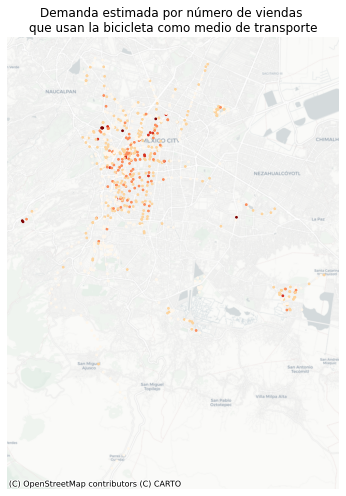

In [21]:
ax = cl.to_crs(epsg=3857).plot(column='POBTOT', scheme='naturalbreaks',
                               markersize=3, cmap='OrRd', figsize=(7,7))
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) 
ax.set_axis_off()
plt.title('Demanda estimada por número de viendas \nque usan la bicicleta como medio de transporte')
plt.tight_layout()
plt.show()

# Exportamos base de datos final de demanda.
gpd.GeoDataFrame(cl[['id_centroid','POBTOT','geometry']]).to_file('products/ciclovias_centroids_demand.gpkg', driver='GPKG', layer='ciclovias')

Una vez con la demanda estimada, pasamos a calcular el modelo de accesibilidad gravitatorio y por el modelo de agente racional RAAM. Primero, calculamos el modelo gravitacional utilizando como oferta el tamaño del establecimiento; en este caso, el número de empleados registrados en el DENUE en cada taller de bicicletas. Previsualizamos la información tanto de talleres como ciclovias y su demanda. 

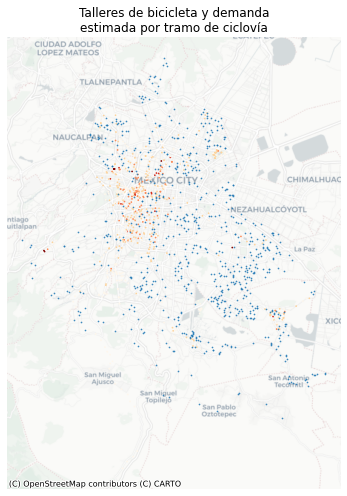

In [27]:
cl = gpd.read_file('products/ciclovias_centroids_demand.gpkg').to_crs(epsg=3857)

ta = gpd.read_file('data/Talleres_Bici.gpkg')
ta['per_ocu'] = ta.per_ocu.apply(lambda x: 1 if x=='0 a 5 personas' else 2)
ta = ta.to_crs(epsg=3857)

ax = cl.plot(column='POBTOT', scheme='naturalbreaks', 
             markersize=.5, cmap='OrRd', figsize=(7,7))
ta.plot(ax=ax, markersize=0.5, alpha=0.8)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) 
ax.set_axis_off()
plt.title('Talleres de bicicleta y demanda\nestimada por tramo de ciclovía')
plt.tight_layout()
plt.show()


Seguimos al cálculo del modelo gravitacional

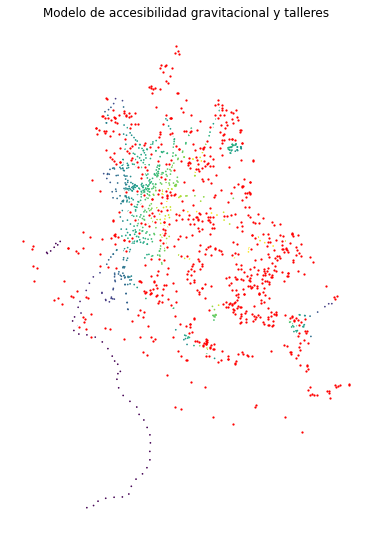

In [28]:
# Creamos el objeto access para calcular distancia euclidiana
A = Access(demand_df            = cl,
           demand_index         = 'id_centroid',
           demand_value         = 'POBTOT',
           supply_df            = ta,
           supply_index         = 'id',
           supply_value         = 'per_ocu')

# Calculamos las distancias
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)
cost = A.cost_df
gravity = weights.gravity(scale = 60, alpha = -1)
gravity_mod = A.weighted_catchment(name='gravity', weight_fn=gravity)

fig = cl[['id_centroid','geometry']].set_index('id_centroid').join(A.access_df, how='inner')
base = fig.plot('gravity_per_ocu', legend = False, 
                figsize = (8, 8), 
                cmap = 'viridis', 
                markersize = .5, 
                alpha = 1,
                vmin = fig['gravity_per_ocu'].quantile(0.05), 
                vmax = fig['gravity_per_ocu'].quantile(0.95))
# Plot it twice, so that the points' edgecolor does not hide other points' centers.
ta.plot(ax=base, markersize=20, color='white')
ta.plot(ax=base, markersize=5, color='red', edgecolor = "white", linewidth = 0)
plt.title('Modelo de accesibilidad gravitacional y talleres')
plt.tight_layout()
base.set_axis_off()
plt.show()

Pasamos el modelo de Agente Racional.

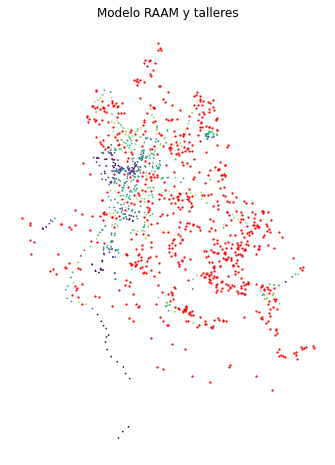

In [29]:
# Creamos modelo access
A = Access(demand_df            = cl,
           demand_index         = 'id_centroid',
           demand_value         = 'POBTOT',
           supply_df            = ta,
           supply_index         = 'id',
           supply_value         = 'per_ocu',
           cost_df              = cost,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean')
raam_mod = A.raam(name='raam')

# Mapeamos el resultado
cmap = matplotlib.cm.viridis
fig = cl[['id_centroid','geometry']].set_index('id_centroid').join(A.access_df, how='inner')
base = fig.plot('raam_per_ocu', legend = False, 
                figsize = (8, 8), 
                cmap = cmap.reversed(), 
                markersize = .5, 
                alpha = 1,
                vmin = fig['raam_per_ocu'].quantile(0.05), 
                vmax = fig['raam_per_ocu'].quantile(0.95))
# Plot it twice, so that the points' edgecolor does not hide other points' centers.
ta.plot(ax=base, markersize=20, color='white')
ta.plot(ax=base, markersize=5, color='red', edgecolor = "white", linewidth = 0)
base.set_axis_off()
plt.title('Modelo RAAM y talleres')
plt.show()

Comparamos ambos modelos y observamos que el modelo RAAM presenta un punto de bajo acceso en las colonias de Juaréz, Roma Norte, San Rafael, etc. Lo anterior hace sentido, porque la formula de del RAAM considera la saturación del servicio de talleres y, si comparamos con el mapa de la demanda, observamos que justo en esa zona hay una saturación. A diferencia del modelo RAAM, el modelo gravitatorio nos muestra que la amplia concentración de talleres se encuentra en la zona centro de la ciudad en contraste con las ciclovías más alejadas. 

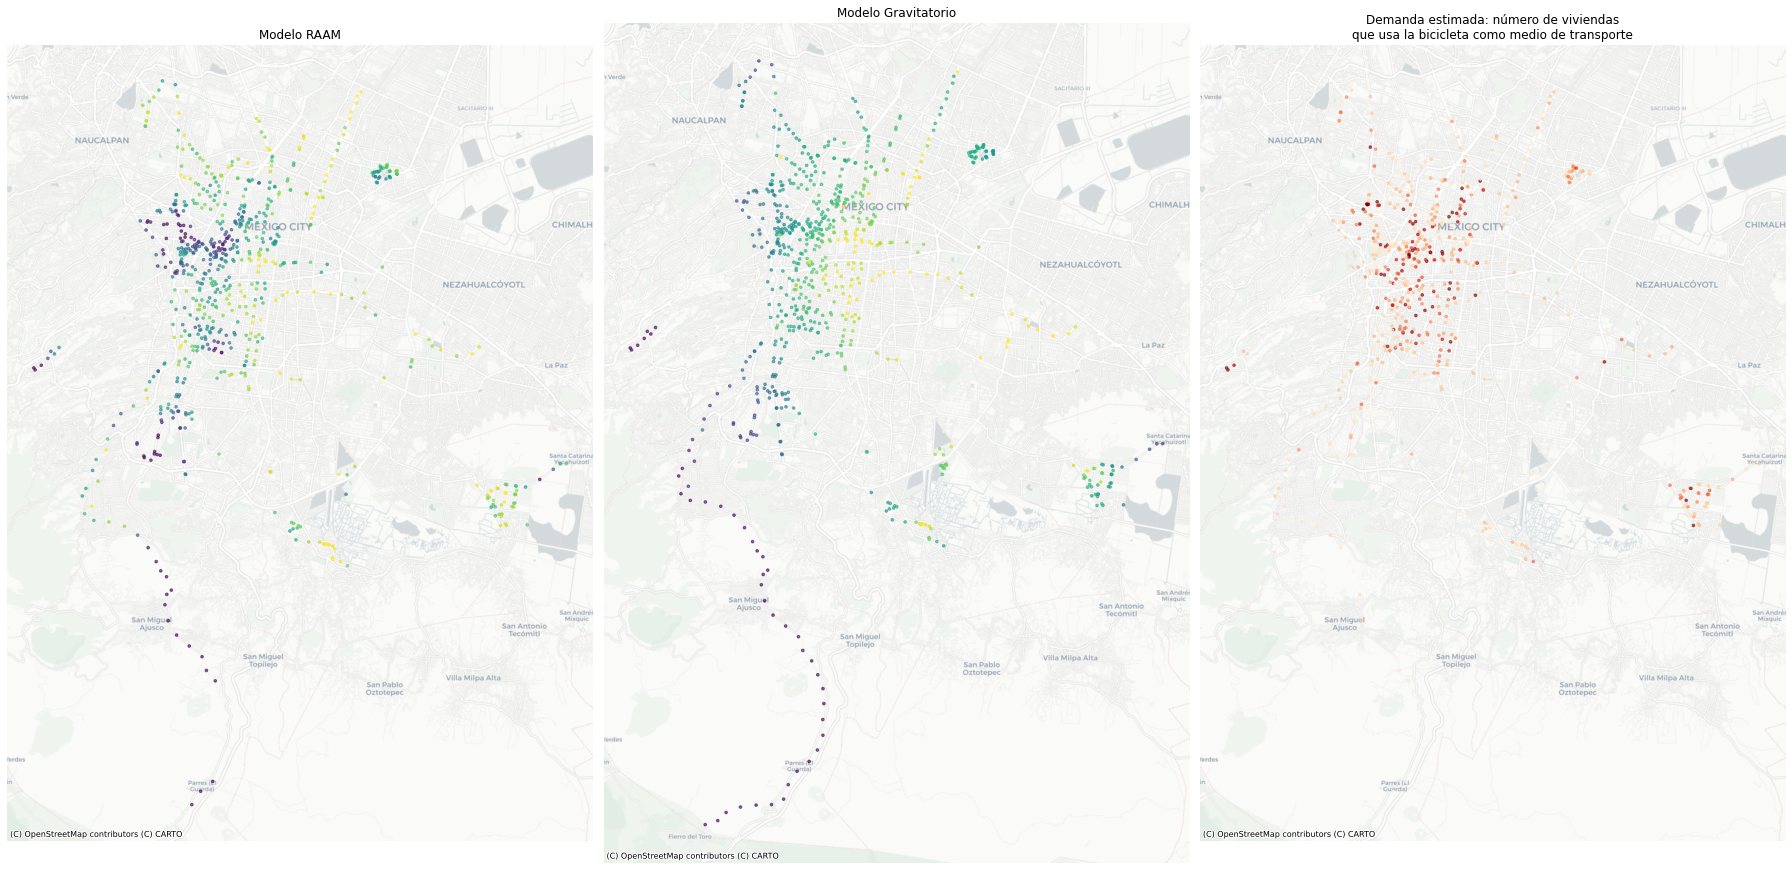

In [30]:
# Guardamos información
mapa_accesibilidad = cl.set_index('id_centroid')[['geometry','POBTOT']].join([gravity_mod,raam_mod], how = "inner")
mapa_accesibilidad.columns = ['geometry','demanda','gravity','raam']

fig, ax = plt.subplots(1,3, figsize=(25,15))
cmap = matplotlib.cm.viridis
mapa_accesibilidad.to_crs(epsg=3857).plot('raam', legend = False,
                                          cmap =  cmap.reversed(), 
                                          markersize = 7, alpha = 0.6, ax = ax[0],
                                          vmin = mapa_accesibilidad['raam'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['raam'].quantile(0.95),
                                          )
mapa_accesibilidad.to_crs(epsg=3857).plot('gravity', legend = False,
                                          cmap =  cmap, 
                                          markersize = 7, alpha = 0.6, ax = ax[1],
                                          vmin = mapa_accesibilidad['gravity'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['gravity'].quantile(0.95),
                                          )
mapa_accesibilidad.to_crs(epsg=3857).plot('demanda', legend = False,
                                          cmap = 'OrRd', 
                                          markersize = 7, alpha = 0.6, ax = ax[2],
                                          vmin = mapa_accesibilidad['demanda'].quantile(0.05), 
                                          vmax = mapa_accesibilidad['demanda'].quantile(0.95),
                                          )
ax[0].set(title='Modelo RAAM')
ax[1].set(title='Modelo Gravitatorio')
ax[2].set(title='Demanda estimada: número de viviendas\nque usa la bicicleta como medio de transporte')
for i in range(len(ax)):
    ax[i].set_axis_off()
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)    
plt.tight_layout()
plt.show()

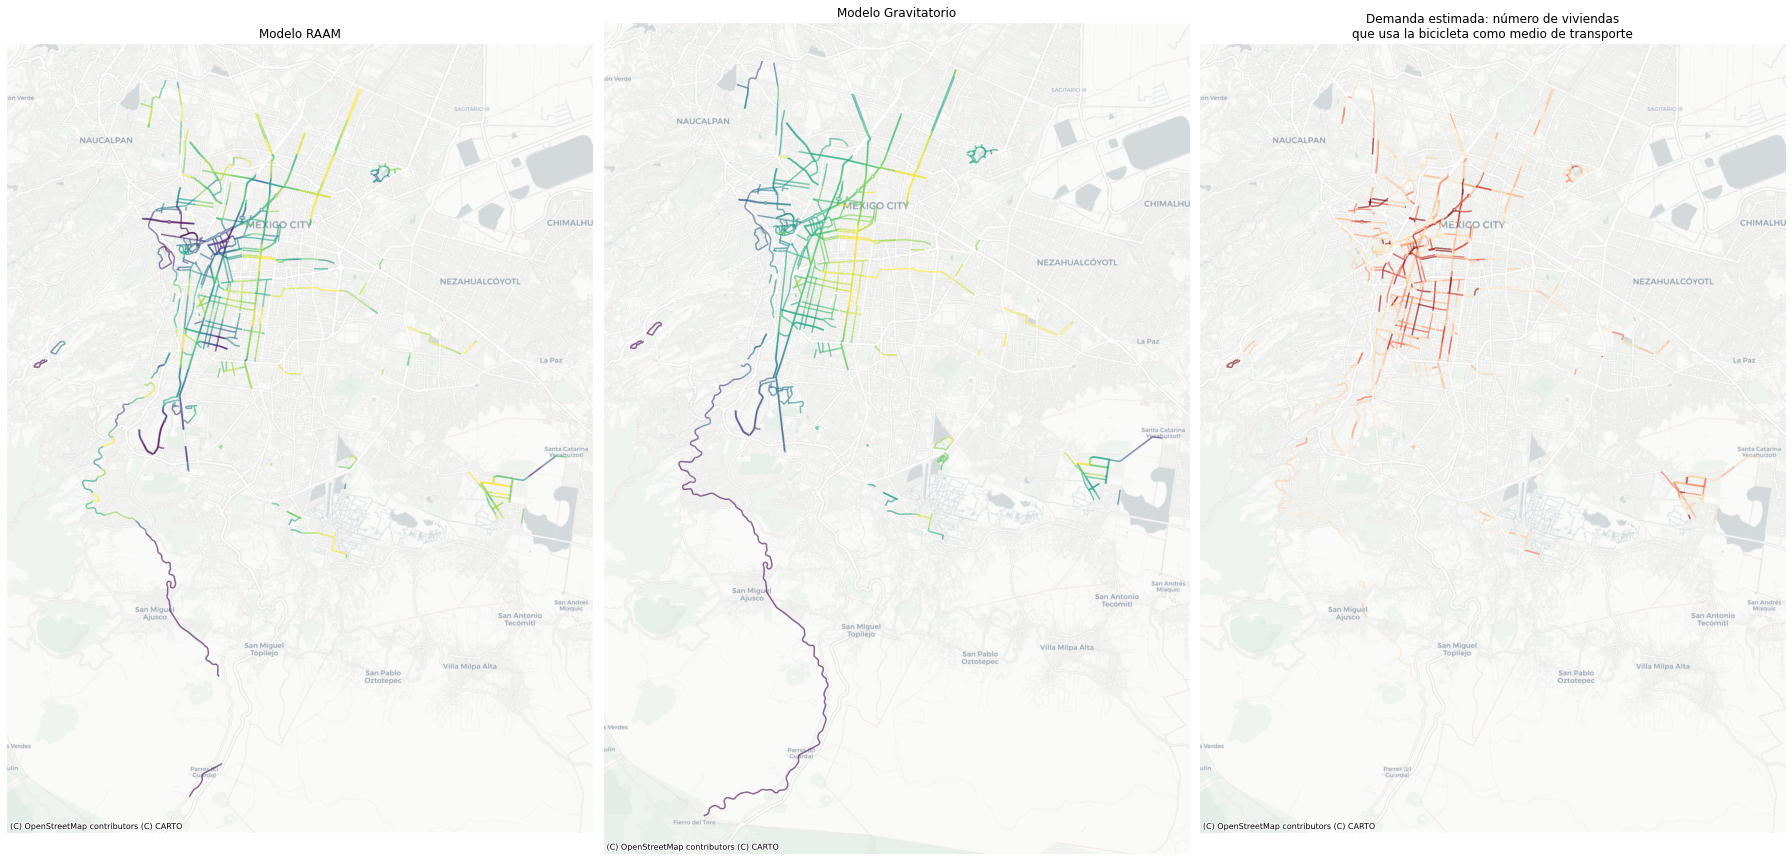

In [49]:
# Mapas con ciclovias lineales
cll = gpd.read_file('products/ciclovias_lines.gpkg').to_crs(3857)
cll = cll.join(mapa_accesibilidad[['raam','gravity','demanda']])

fig, ax = plt.subplots(1,3, figsize=(25,15))
cmap = matplotlib.cm.viridis
cll.to_crs(epsg=3857).plot('raam', legend = False,
                           cmap =  cmap.reversed(), 
                           markersize = 7, alpha = 0.6, ax = ax[0],
                           vmin = mapa_accesibilidad['raam'].quantile(0.05), 
                           vmax = mapa_accesibilidad['raam'].quantile(0.95))
cll.to_crs(epsg=3857).plot('gravity', legend = False,
                           cmap =  cmap, 
                           markersize = 7, alpha = 0.6, ax = ax[1],
                           vmin = mapa_accesibilidad['gravity'].quantile(0.05),
                           vmax = mapa_accesibilidad['gravity'].quantile(0.95))
cll.to_crs(epsg=3857).plot('demanda', legend = False,
                           cmap = 'OrRd', 
                           markersize = 7, alpha = 0.6, ax = ax[2],
                           vmin = mapa_accesibilidad['demanda'].quantile(0.05), 
                           vmax = mapa_accesibilidad['demanda'].quantile(0.95))
ax[0].set(title='Modelo RAAM')
ax[1].set(title='Modelo Gravitatorio')
ax[2].set(title='Demanda estimada: número de viviendas\nque usa la bicicleta como medio de transporte')
for i in range(len(ax)):
    ax[i].set_axis_off()
    ctx.add_basemap(ax[i], source=ctx.providers.CartoDB.Positron)    
plt.tight_layout()
plt.show()

# Exportamos datos
mapa_accesibilidad.to_crs(32614).to_file('products/ciclovias_accesibilidad.gpkg', driver='GPKG', layer='accesibilidad')

**Conclusiones**

Según el Censo de Población y Vivienda 2020,en México existen más de 500,000 viviendas particulares habitadas que cuentan al menos con una bicicleta como medio de transporte dentro de las 16 alcaldías. Esto tiene una implicación real dependiendo de las condiciones materiales a las cuales
la persona está sometida en su vida diaria. 

Para dicha explcación sobre el modelo de demanda referente al uso de la bicicleta, se generó un modelo OLS, con el cual se pudo generar una extrapolación. Dichas variables desprendidas de los datos del censo fueron analizados por medio de regresión. Esto generó una serie de productos que reconocen la demanda estimada por número de viviendas que ocupan la bicicleta como medio de transporte, la referencia sobre la demanda estimada referente al tramo de ciclovía. Seguido del modelo accesibilidad gravitacional a talleres y el modelo RAAM a talleres de bicicletas.

Con la obtención de los modelos se puede observar que el uso de la bicicleta en referencia a la oferta de talleres de bicicleta, puede explicarse debido a la saturación de servicio en zonas de una alta demanda en el uso de bicletas, destacando que el modelo RAAM y la demanda estimada del número de bicis, nos dejan ver que en zonas con una alta demanda de bicicletas existe una saturacion de los servicios de taller.
